This jupyter notebook tries to predict geomagnetic storms in the next hour based on the last N hours using recurrent neural networks (RNN, more especifically GRU) for regression (Dst value) classification.
It is divided in 4 parts:
* Loading libraries and data.
* Transforming the dataset and doing some feature engineering.
* Making and fiting the model.
* Checking the results.

# Forecasting geomagnetic storms using recurrent neural networks (RNN) for regression
***


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score, mean_absolute_error, mean_squared_error)

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import AUC, Precision, Recall

from keras.losses import MeanSquaredError, MeanAbsoluteError

In [53]:
# Load raw dataframe
df = pd.read_csv("../data/data_storms.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     244535 non-null  object 
 1   ABS_B        244535 non-null  float64
 2   F            244535 non-null  float64
 3   BX_GSE       244535 non-null  float64
 4   BY_GSE       244535 non-null  float64
 5   BZ_GSE       244535 non-null  float64
 6   SIGMA-ABS_B  244535 non-null  float64
 7   SIGMA-B      244535 non-null  float64
 8   SIGMA-Bx     244535 non-null  float64
 9   SIGMA-By     244535 non-null  float64
 10  SIGMA-Bz     244535 non-null  float64
 11  T            244535 non-null  float64
 12  N            244535 non-null  float64
 13  V            244535 non-null  float64
 14  Ratio        244535 non-null  float64
 15  Pressure     244535 non-null  float64
 16  R            244535 non-null  int64  
 17  DST          244535 non-null  float64
 18  storm_now    244535 non-

# Changing the dataframe to fit RNN
***

In [54]:
# Ensure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244535 entries, 0 to 244534
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     244535 non-null  datetime64[ns]
 1   ABS_B        244535 non-null  float64       
 2   F            244535 non-null  float64       
 3   BX_GSE       244535 non-null  float64       
 4   BY_GSE       244535 non-null  float64       
 5   BZ_GSE       244535 non-null  float64       
 6   SIGMA-ABS_B  244535 non-null  float64       
 7   SIGMA-B      244535 non-null  float64       
 8   SIGMA-Bx     244535 non-null  float64       
 9   SIGMA-By     244535 non-null  float64       
 10  SIGMA-Bz     244535 non-null  float64       
 11  T            244535 non-null  float64       
 12  N            244535 non-null  float64       
 13  V            244535 non-null  float64       
 14  Ratio        244535 non-null  float64       
 15  Pressure     244535 non-null  floa

In [55]:
# Analyze storm distribution over time
# Number of storm-hours per year
df_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum'])
print(df_storms)

          sum
datetime     
1995      371
1996       31
1997      284
1998      555
1999      424
2000      554
2001      677
2002      904
2003      335
2004      354
2005      533
2006       93
2007       20
2008       12
2009       17
2010       84
2011      201
2012      425
2013      224
2014      163
2015      659
2016      219
2017      213
2018       80
2019       24
2020       21
2021       51
2022      159
2023      386
2024      572


In [56]:
# Number of hours with storms (count should be 8760 [24*365] or 8784 for leap years)
# values below 8784 indicate some missing data
yearly_storms = df.groupby(df['datetime'].dt.year)['storm_now'].agg(['sum', 'count'])
print("\nHours with storm distribution by year:")
print(yearly_storms)


Hours with storm distribution by year:
          sum  count
datetime            
1995      371   8628
1996       31   8578
1997      284   8121
1998      555   8328
1999      424   6840
2000      554   7034
2001      677   7466
2002      904   7613
2003      335   6439
2004      354   6948
2005      533   8508
2006       93   7723
2007       20   8230
2008       12   8649
2009       17   8550
2010       84   7966
2011      201   8313
2012      425   8651
2013      224   8412
2014      163   6897
2015      659   8670
2016      219   8741
2017      213   8712
2018       80   8751
2019       24   8643
2020       21   8722
2021       51   8549
2022      159   8716
2023      386   8614
2024      572   8523


In [57]:
# chronological split is important for time series, so let's sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)
assert df['datetime'].is_monotonic_increasing

print(df.head())

             datetime  ABS_B    F  BX_GSE  BY_GSE  BZ_GSE  SIGMA-ABS_B  \
0 1995-01-01 00:00:00    4.0  3.9    -0.6     3.2    -2.1          0.6   
1 1995-01-01 01:00:00    3.0  2.9    -0.9     2.4    -1.3          0.3   
2 1995-01-01 02:00:00    3.2  1.9     0.5     1.8    -0.4          0.7   
3 1995-01-01 03:00:00    4.3  4.0    -3.2     2.5     0.3          0.4   
4 1995-01-01 04:00:00    4.8  4.8    -4.3     2.1     0.3          0.1   

   SIGMA-B  SIGMA-Bx  SIGMA-By  SIGMA-Bz        T     N      V  Ratio  \
0      1.2       0.5       0.9       0.5  15816.0  16.3  315.0  0.016   
1      0.8       0.2       0.3       0.8  15601.0  18.8  315.0  0.013   
2      2.6       1.6       0.9       1.8  20703.0  19.3  320.0  0.012   
3      1.5       1.2       0.5       0.8  25094.0  16.4  317.0  0.013   
4      0.3       0.2       0.2       0.2  25604.0  14.5  313.0  0.015   

   Pressure   R  DST  storm_now  
0      2.87  13 -2.0          0  
1      3.28  13  3.0          0  
2      3.46  1

# Fitting the model
***

In [58]:
# let's check all columns to drop some (in the features) on the next cell
print(df.columns)

Index(['datetime', 'ABS_B', 'F', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'SIGMA-ABS_B',
       'SIGMA-B', 'SIGMA-Bx', 'SIGMA-By', 'SIGMA-Bz', 'T', 'N', 'V', 'Ratio',
       'Pressure', 'R', 'DST', 'storm_now'],
      dtype='object')


In [59]:
# Separate features and target
# I started using the DST feature, and it is very useful, but it is not always available in real-time forecasts
# datetime may not be a problem or leak information, but I am excluding it just to be sure
feature_cols = [col for col in df.columns if col not in ['datetime', 'DST', 'storm_now']] 
X = df[feature_cols].values
y = df['DST'].values

In [60]:
# Checking feature names
print(df[feature_cols].columns)

Index(['ABS_B', 'F', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'SIGMA-ABS_B', 'SIGMA-B',
       'SIGMA-Bx', 'SIGMA-By', 'SIGMA-Bz', 'T', 'N', 'V', 'Ratio', 'Pressure',
       'R'],
      dtype='object')


In [61]:
# Scale features
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

In [62]:
# This function will transform the 2D data (X) into a 3D array with the shape: 
# [number_of_samples, N_timesteps, number_of_features]
def create_sequences(X, y, time_steps):
    """
    Transforms 2D data into 3D sequences for RNN/GRU input.

    X: 2D array of features (all time steps)
    y: 1D array of targets (all time steps)
    time_steps: The lookback window (N)
    """
    Xs, ys = [], []
    # Loop starts at 'time_steps' to ensure the first sequence is complete.
    # The sequence X[i-time_steps:i] (N historical points) predicts y[i] (the next point).
    for i in range(time_steps, len(X)):
        # Input sequence: data from time t-N up to t-1
        Xs.append(X[i-time_steps:i])
        # Target: data at time t (what we are predicting)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# lookback window of N hours
time_steps = 3 

X_sequences, y_targets = create_sequences(X_scaled, y_scaled.ravel(), time_steps)

# Check the new shape
print(X_sequences.shape) # Should look like (244532, N, 17)
print(y_targets.shape)   # Should look like (244532,)

(244532, 3, 16)
(244532,)


In [63]:
# Split into train and test sets

# Use last 20% as test set and NO RANDOM SPLIT FOR TIME SERIES
split_idx = int(len(X_sequences) * 0.8)
X_train, X_test = X_sequences[:split_idx], X_sequences[split_idx:]
y_train, y_test = y_targets[:split_idx], y_targets[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 195625
Test samples: 48907

Class distribution in training set:
Percentage of positive cases in train: -3.71%

Class distribution in test set:
Percentage of positive cases in test: 14.84%


In [64]:
# Get the final feature count and time steps for the model input layer
n_features = X_train.shape[2]
time_steps = X_train.shape[1]

In [65]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    model = load_model('./Data/storms_keras_RNN_Dst.keras')
except:
    print("No saved model found, proceeding to train a new model.")

No saved model found, proceeding to train a new model.


In [66]:
def create_model(n_features, time_steps, units_gru, units_dense, dropout_rate, learning_rate):

    """Create model with configurable hyperparameters"""
    model = Sequential([
            # 0. Input Layer
            Input(shape=(time_steps, n_features)),

            # 1. Sequential Layer (GRU)
            GRU(units=units_gru, activation='tanh', return_sequences=False),
            Dropout(dropout_rate),
            
            # 2. Classification Layer (Dense)
            Dense(units=units_dense, activation='relu'),
            Dropout(dropout_rate),
            
            # 3. Output Layer
            Dense(units=1, activation='linear')  # Linear activation for regression
        ])
        
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mae',
        metrics=['mse', 'mae']
    )
    return model

In [67]:
def randomized_search(X_train, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'units_gru': [32, 64, 128, 256],
        'units_dense': [16, 32, 64],
        'dropout_rate': [0.1, 0.3, 0.5],
        'learning_rate': [1e-3, 5e-4, 1e-4],
        'time_steps': [3, 6, 12, 24],
        'batch_size': [32, 64, 128]
    }
    
    # support both 2D and 3D inputs
    if X_train.ndim == 3:
        n_samples, time_steps_from_X, n_features = X_train.shape
    else:
        n_samples, n_features = X_train.shape
        time_steps_from_X = None
    
    # Compute class weights for imbalanced dataset
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter distribution
        params = {
            'units_gru': int(np.random.choice(param_distributions['units_gru'])),
            'units_dense': int(np.random.choice(param_distributions['units_dense'])),
            'dropout_rate': float(np.random.choice(param_distributions['dropout_rate'])),
            'learning_rate': float(np.random.choice(param_distributions['learning_rate'])),
            'time_steps': int(np.random.choice(param_distributions['time_steps'])),
            'batch_size': int(np.random.choice(param_distributions['batch_size']))
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # If X_train already has time_steps dimension, ensure consistency
        if time_steps_from_X is not None and params['time_steps'] != time_steps_from_X:
            # skip incompatible combinations
            print(f"  -> Skipping params because X_train.time_steps={time_steps_from_X} != sampled time_steps={params['time_steps']}")
            continue
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation MSE
        mse = max(history.history.get('mse', [0]))
        print(f"  -> mse: {mse:.4f}")
        
        # Store results
        results.append({**params, 'mse': mse})
        
        # Update best
        if mse > best_score:
            best_score = mse
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation MSE: {best_score:.4f}")
    
    return best_params, best_score, results

In [68]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train, 
    y_train, 
    n_iter=5
)

Testing 5 random combinations...

[1/5] Testing: {'units_gru': 64, 'units_dense': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'time_steps': 3, 'batch_size': 64}
  -> mse: 0.9792

[2/5] Testing: {'units_gru': 128, 'units_dense': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'time_steps': 6, 'batch_size': 64}
  -> Skipping params because X_train.time_steps=3 != sampled time_steps=6

[3/5] Testing: {'units_gru': 256, 'units_dense': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'time_steps': 12, 'batch_size': 32}
  -> Skipping params because X_train.time_steps=3 != sampled time_steps=12

[4/5] Testing: {'units_gru': 256, 'units_dense': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'time_steps': 3, 'batch_size': 64}
  -> mse: 0.9341

[5/5] Testing: {'units_gru': 256, 'units_dense': 16, 'dropout_rate': 0.3, 'learning_rate': 0.0005, 'time_steps': 3, 'batch_size': 32}
  -> mse: 0.9423
Best Parameters:
  units_gru: 64
  units_dense: 64
  dropout_rate: 0.5
  learning_rate: 0.0005

In [69]:
# Create final model with best parameters
model = Sequential([
    Input(shape=(time_steps, n_features)),
    GRU(best_params['units_gru'], activation='tanh'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_dense'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(1, activation='linear')
])

In [70]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mae',
    metrics=['mse', 'mae']
)

In [71]:
# Compute class weights for imbalanced dataset
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [72]:
# Train the best model
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 119.9814 - mae: 0.6040 - mse: 0.9685 - val_loss: 0.5374 - val_mae: 0.5374 - val_mse: 0.7058
Epoch 2/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 112.8796 - mae: 0.5853 - mse: 0.9347 - val_loss: 0.5252 - val_mae: 0.5252 - val_mse: 0.6787
Epoch 3/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 111.6099 - mae: 0.5808 - mse: 0.9285 - val_loss: 0.5373 - val_mae: 0.5373 - val_mse: 0.7119
Epoch 4/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 111.1998 - mae: 0.5804 - mse: 0.9305 - val_loss: 0.5297 - val_mae: 0.5297 - val_mse: 0.6978
Epoch 5/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 110.6126 - mae: 0.5785 - mse: 0.9289 - val_loss: 0.5220 - val_mae: 0.5220 - val_mse: 0.6781
Epoch 6/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 110.5846 - mae: 0.5798 - mse: 0.9351 - val_loss: 0.5315 - val_mae: 0.5315 - val_mse: 0.6988
Epoch 7/10
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 110.1877 - mae

In [73]:
# evaluate
results = model.evaluate(X_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.48879873752593994, 'compile_metrics': 0.7601723074913025}


In [74]:
# Save the best model
model.save("../data/storms_keras_RNN_Dst.keras")
print("Best model saved to ../data/storms_keras_RNN_Dst.keras")

Best model saved to ../data/storms_keras_RNN_Dst.keras


In [75]:
# Predict
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

1529/1529 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step


In [76]:
# un-scale final predictions before calculating the final metrics

# 1. Reshape scaled true values for inverse transformation
# y_test_scaled is usually 1D, but the scaler expects 2D
y_test_scaled_2d = y_test.reshape(-1, 1)

# 2. Inverse Transform the predictions and the true values
# This converts the values back into the original Dst units (nT)
y_pred_unscaled = y_scaler.inverse_transform(y_pred)
y_true_unscaled = y_scaler.inverse_transform(y_test_scaled_2d)

# 3. Flatten the unscaled arrays to 1D for metric calculation (optional but clean)
y_pred_unscaled = y_pred_unscaled.flatten()
y_true_unscaled = y_true_unscaled.flatten()

# Results
***

In [78]:
# Metrics

if len(np.unique(y_true_unscaled)) > 1:
    final_mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    final_rmse = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))

    metrics_table = pd.DataFrame({
        'Metric': ['MAE', 'rmse'],
        'Score': [final_mae, final_rmse]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_true_unscaled. Metrics skipped.")


Evaluation Metrics:
Metric   Score
   MAE 10.9794
  rmse 17.8719



Visualization saved as 'geomag_storm_RNN_Dst_results.png'


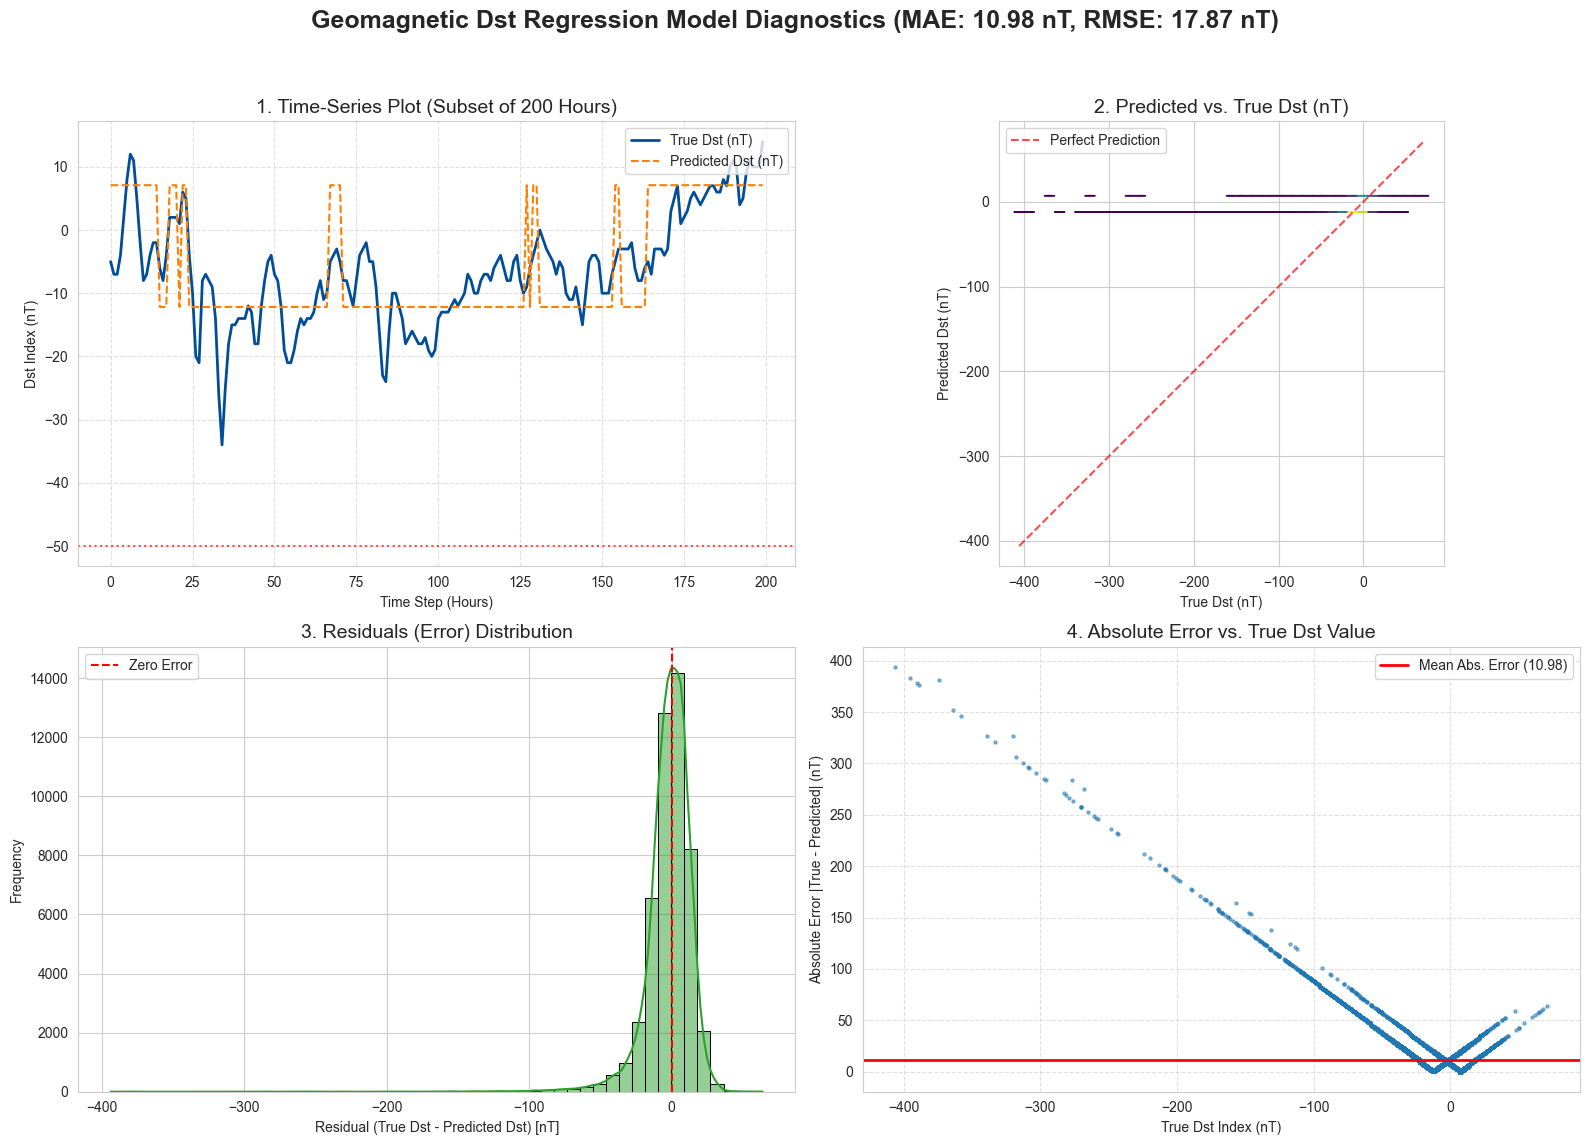

In [80]:
# Visualizations

# Calculate the residuals/errors
residuals = y_true_unscaled - y_pred_unscaled
abs_errors = np.abs(residuals)

# Calculate metrics for display
mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))


# --- 2. PLOTTING FUNCTION ---
def plot_regression_diagnostics(y_true, y_pred, mae, rmse):
    """
    Creates a 2x2 figure containing the four key regression diagnostic plots
    for the Dst index forecast.
    """
    
    residuals = y_true - y_pred
    abs_errors = np.abs(residuals)
    
    # Set the plotting style
    sns.set_style("whitegrid")
    
    # Create the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.suptitle(
        f"Geomagnetic Dst Regression Model Diagnostics (MAE: {mae:.2f} nT, RMSE: {rmse:.2f} nT)", 
        fontsize=18, 
        fontweight='bold'
    )

    # --- Plot 1: Time-Series Plot (Predicted vs. True) ---
    ax1 = axes[0, 0]
    # Restrict the view to a short, meaningful window (e.g., 200 data points)
    window_size = 200
    ax1.plot(y_true[:window_size], label='True Dst (nT)', color='#004D99', linewidth=2)
    ax1.plot(y_pred[:window_size], label='Predicted Dst (nT)', color='#FF7F00', linestyle='--', linewidth=1.5)
    
    ax1.set_title(f'1. Time-Series Plot (Subset of {window_size} Hours)', fontsize=14)
    ax1.set_xlabel('Time Step (Hours)')
    ax1.set_ylabel('Dst Index (nT)')
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Highlight the storm region (Dst < -50 nT)
    ax1.axhline(y=-50, color='r', linestyle=':', alpha=0.7, label='Storm Threshold')
    
    # --- Plot 2: Scatter Plot (Predicted vs. True) ---
    ax2 = axes[0, 1]
    
    # Use hexbin for dense data to show density/clusters
    ax2.hexbin(y_true, y_pred, gridsize=40, cmap='viridis', mincnt=1)
    
    # Plot the perfect prediction line (y=x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction', alpha=0.7)
    
    ax2.set_title('2. Predicted vs. True Dst (nT)', fontsize=14)
    ax2.set_xlabel('True Dst (nT)')
    ax2.set_ylabel('Predicted Dst (nT)')
    ax2.legend()
    ax2.set_aspect('equal', adjustable='box')


    # --- Plot 3: Error Distribution (Histogram) ---
    ax3 = axes[1, 0]
    # Use seaborn for a nice distribution plot
    sns.histplot(residuals, bins=50, kde=True, ax=ax3, color='#2CA02C', edgecolor='black')
    
    # Add a line at zero error
    ax3.axvline(0, color='r', linestyle='--', linewidth=1.5, label='Zero Error')
    
    ax3.set_title('3. Residuals (Error) Distribution', fontsize=14)
    ax3.set_xlabel('Residual (True Dst - Predicted Dst) [nT]')
    ax3.set_ylabel('Frequency')
    ax3.legend()


    # --- Plot 4: Error Magnitude vs. Dst Value ---
    ax4 = axes[1, 1]
    ax4.scatter(y_true, abs_errors, s=5, alpha=0.5, color='#1F77B4')
    
    # Add line showing the mean absolute error
    ax4.axhline(mae, color='red', linestyle='-', linewidth=2, label=f'Mean Abs. Error ({mae:.2f})')
    
    ax4.set_title('4. Absolute Error vs. True Dst Value', fontsize=14)
    ax4.set_xlabel('True Dst Index (nT)')
    ax4.set_ylabel('Absolute Error |True - Predicted| (nT)')
    ax4.legend()
    ax4.grid(True, linestyle='--', alpha=0.6)
    
    # Final layout adjustments
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust to make space for suptitle
    plt.savefig('../figures/geomag_storm_RNN_Dst_results.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'geomag_storm_RNN_Dst_results.png'")
    plt.show()

# --- 3. EXECUTION ---
if __name__ == '__main__':
    plot_regression_diagnostics(y_true_unscaled, y_pred_unscaled, mae, rmse)